## Imports

In [116]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording           # (Use this for old data)
from load_recording_data import LoadRecordingData#, Recording            # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools

In [117]:
gpus = tf.config.list_physical_devices('GPU')
gpu_id = 3
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

## Load Data

In [118]:
intrasTrain, extrasTrain, intrasTest, extrasTest = LoadRecordingData()
# intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
# idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20, random_state=42)

# extrasTrain = extrasTrainVal[idx_train]
# intrasTrain = intrasTrainVal[idx_train]
# extrasVal = extrasTrainVal[idx_val]
# intrasVal = intrasTrainVal[idx_val]

# dataset = LoadRecordingData()
# idx_train, idx_test = train_test_split(np.arange(len(intrasRaw)), test_size=0.25, random_state=42)

# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [119]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

### Smooth the data by applying moving filter

In [5]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)
temp = []

for rec in extrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
extrasTrain = np.array(temp)

# Validation set
# temp = []

# for rec in intrasVal:
#     temp.append(moving_filter(rec, windowSize))
    
# intrasVal = np.array(temp)
# temp = []

# for rec in extrasVal:
#     temp.append(moving_filter(rec, windowSize))
    
# extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)
temp = []

for rec in extrasTest:
    temp.append(moving_filter(rec, windowSize))
    
extrasTest = np.array(temp)

### Function to extract features

In [120]:
def GetFeatures(intras, extras):
    X = []
    Y = []
    windowSize = 20
    
#     featureNames = ['d2eAP', 'deAP', 'eAP', 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)']#, 'distFromMax', 'distFromMin']
#     s = [i for i in range(len(featureNames))]
#     combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
#     featureCombs = []
    
#     for comb in combs[1:]:
#         for tpl in comb:
#             name = ""

#             for ind in tpl:
#                 name += "*"+featureNames[ind]

#             featureCombs.append(name)

    
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
    
    for i in range(len(extras)):
#         iAP = intras[i]
#         diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
#         d2iAP = np.array(moving_filter(np.gradient(diAP), windowSize))

#         eAP = extras[i]
#         deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
#         d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
            
        iAP = intras[i]
        diAP = np.gradient(iAP)
        d2iAP = np.gradient(diAP)

        eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)


        featureMatrix = [d2iAP, diAP, iAP, t]#, np.exp(d2eAP), np.exp(deAP), np.exp(eAP)]
#         featureList = [d2eAP, deAP, eAP, np.exp(d2eAP), np.exp(deAP), np.exp(eAP)]
    

#         maxInd = np.argmax(eAP[:1500])
#         minInd = 1500 + np.argmin(eAP[1500:])

#         distFromMax = [i for i in range(len(extras[0]))]
#         distFromMin = [i for i in range(len(extras[0]))]

#         distFromMax = np.exp(-np.absolute(distFromMax - maxInd))
#         distFromMin = np.exp(-np.absolute((distFromMin - minInd)/50))

#         featureList.append(distFromMax)
#         featureList.append(distFromMin)
            
#         featureMatrix = []
        
#         for comb in combs[1:]:
#             for tpl in comb:
#                 feature = 1
                
#                 for ind in tpl:
#                     feature = feature*featureList[ind]
                    
#                 featureMatrix.append(feature)
        
        X.append(np.array(featureMatrix).T)
        Y.append(eAP)
        
#     X = np.array(X)
#     Y = np.array(Y)
     
    return X, Y

### Extract features from train, val and test data

In [121]:
X0, Y0 = GetFeatures(intrasTrain, extrasTrain)

In [122]:
# X_val0, Y_val0 = GetFeatures(intrasVal, extrasVal)

In [123]:
X_test0, Y_test0 = GetFeatures(intrasTest, extrasTest)

## SINDy inverse model (iAP to eAP)

In [125]:
differentiation_method = ps.FiniteDifference(order=2)

feature_library = ps.PolynomialLibrary(degree=2)
#feature_library = ps.FourierLibrary(n_frequencies=5)

library_functions = [
    lambda x: np.exp(x),
#     lambda x: 1.0 / x,
#     lambda x: x,
#     lambda x, y: np.sin(x + y),
]

library_function_names = [
    lambda x: "exp(" + x + ")",
#     lambda x: "1/" + x,
#     lambda x: x,
#     lambda x, y: "sin(" + x + "," + y + ")",
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

generalized_library = ps.GeneralizedLibrary([feature_library, custom_library])

# optimizer = ps.STLSQ(threshold=0.2, alpha=0.5)
# optimizer = ps.SR3(threshold=0.1, thresholder="l2")
# optimizer = ps.SR3(trimming_fraction=0.1)
# optimizer = ps.SSR(alpha=0.05)
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual")
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual", kappa=1e-3)
# optimizer = ps.FROLS(alpha=0.05)
# optimizer = ps.FROLS(alpha=0.05, kappa=1e-7)
optimizer = Lasso(alpha=0.001, max_iter=2000)

discrete = False

model = ps.SINDy(differentiation_method=differentiation_method,
    feature_library=generalized_library,
    optimizer=optimizer,
    discrete_time=discrete)

model.fit(X0, t=1, x_dot=Y0, multiple_trajectories=True)
model.print()

(x0)' = -0.136 x3 + 0.080 x2^2 + -0.304 x2 x3 + 0.068


### Evaluate model on test data

In [126]:
predD1 = np.array(model.predict(X_test0, multiple_trajectories=True))
predD1 = np.reshape(predD1, (predD1.shape[:2]))
# pred = np.cumsum(predD1, axis=1)
# prediAP_selected = np.cumsum(predd1_selected, axis=1)
yd1 = np.array(Y_test0)
# y = np.cumsum(yd1, axis=1)
# yiAP = np.cumsum(yd1, axis=1)
print("MSE on test d1 with reg_selected", mse(predD1, yd1))
# print("MSE on test d0 with reg_selected", mse(pred, y))
print("MAE on test d1 with reg_selected", mae(predD1, yd1))
# print("MAE on test d0 with reg_selected", mae(pred, y))
print("DTW on test d1 with reg_selected", dtw(predD1, yd1))
# print("DTW on test d0 with reg_selected", dtw(pred, y))

MSE on test d1 with reg_selected 0.0019904299233863354
MAE on test d1 with reg_selected 0.028698266512290085
DTW on test d1 with reg_selected 193.21173507476232


### Prediction plots for a random recording from the test set

231


Text(112.59722222222221, 0.5, 'eAP')

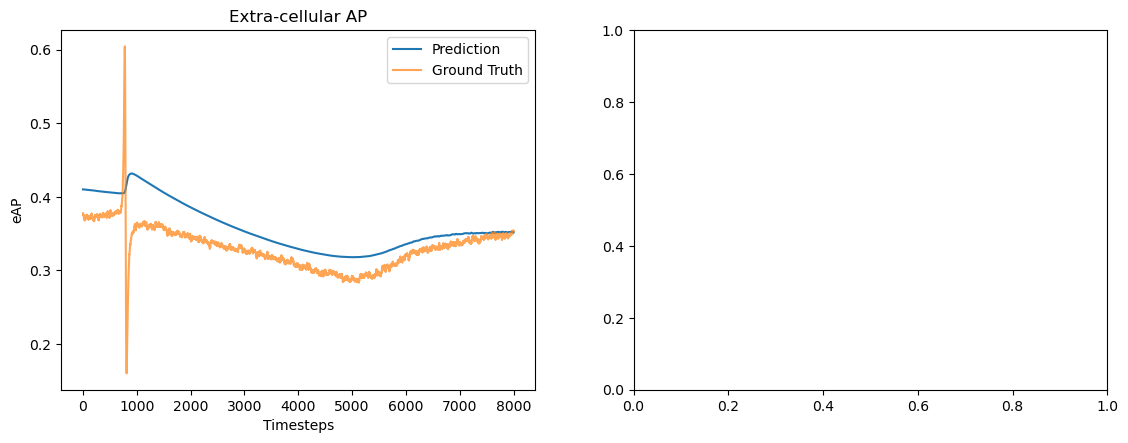

In [115]:
ind = random.randint(0, len(X_test0))
print(ind)
x, y = X_test0[ind], Y_test0[ind]
pred = model.predict(x)

transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig0.tight_layout(pad=4)

# Plot eAP prediction
ax0[0].plot(pred)
ax0[0].plot(y, alpha=transparency)
ax0[0].legend(['Prediction', 'Ground Truth'])
ax0[0].title.set_text("Extra-cellular AP")
ax0[0].set_xlabel("Timesteps")
ax0[0].set_ylabel("eAP")